In [82]:
untraced = []
traced = []

SPS = 0
CPU = 1

def read_file(filename):
    with open(filename) as file:
        t = []
        while True:
            line = file.readline()
            if not line:
                break

            t.append([float(i) for i in line.split()])
    return t

traced = read_file('traced.txt')
untraced = read_file('untraced.txt')


# Garbage Collection Test:

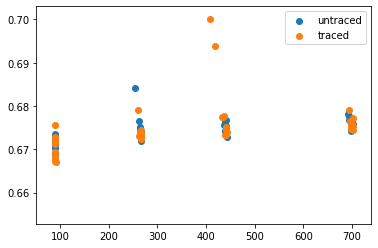

In [44]:
import matplotlib.pyplot as plt

u_ms10 = read_file('gc_test/untraced_nogc.txt')
ms10 = read_file('gc_test/traced_nogc.txt')


ms10_cpu = [m[2] for m in ms10]
ms10_sps = [m[0] for m in ms10]
u_ms10_cpu = [m[2] for m in u_ms10]
u_ms10_sps = [m[0] for m in u_ms10]



plt.scatter(u_ms10_sps, u_ms10_cpu, label='untraced')
plt.scatter(ms10_sps, ms10_cpu, label='traced')
plt.legend()

plt.legend()
plt.show()

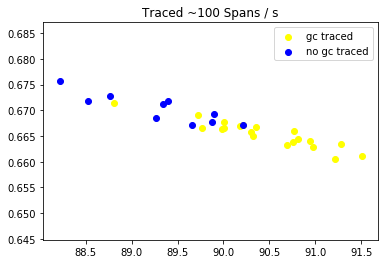

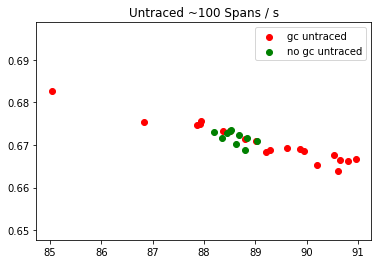

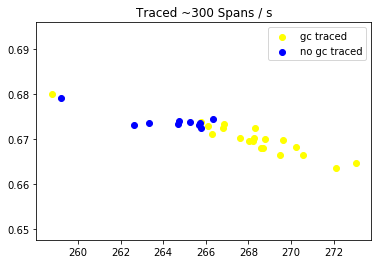

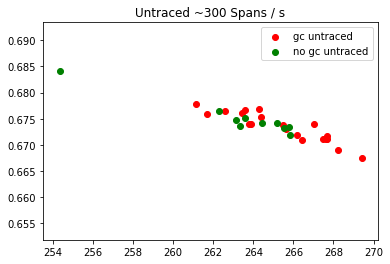

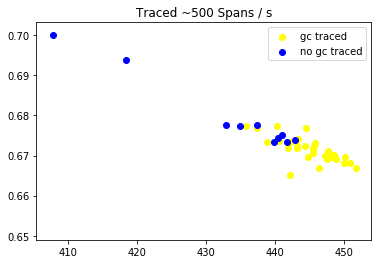

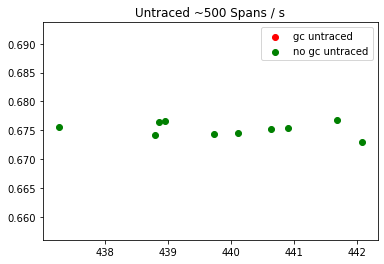

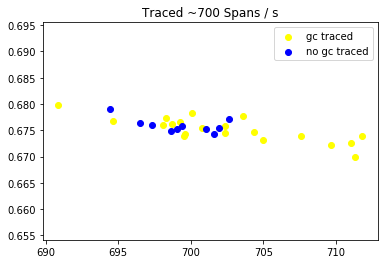

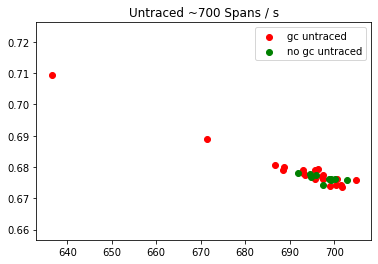

In [43]:
import matplotlib.pyplot as plt

for s in [100, 300, 500, 700]:

    gc_untraced = list(filter(lambda x : abs(x[0] - s) < 100, read_file('gc_test/untraced.txt')))
    gc_traced = list(filter(lambda x : abs(x[0] - s) < 100, read_file('gc_test/traced.txt')))

    no_gc_untraced = list(filter(lambda x : abs(x[0] - s) < 100, read_file('gc_test/untraced_nogc.txt')))
    no_gc_traced = list(filter(lambda x : abs(x[0] - s) < 100, read_file('gc_test/traced_nogc.txt')))

    
    plt.scatter([m[0] for m in gc_traced], [m[2] for m in gc_traced], label='gc traced', color='yellow')
    plt.scatter([m[0] for m in no_gc_traced], [m[2] for m in no_gc_traced], label='no gc traced', color='blue')
    
    plt.title(f'Traced ~{s} Spans / s')
    plt.legend()
    plt.show()
    
    plt.scatter([m[0] for m in gc_untraced], [m[2] for m in gc_untraced], label='gc untraced', color='red')
    plt.scatter([m[0] for m in no_gc_untraced], [m[2] for m in no_gc_untraced], label='no gc untraced', color='green')
    
    
    plt.title(f'Untraced ~{s} Spans / s')
    plt.legend()
    plt.show()



# Large Batch Test (1000 X 10s) 

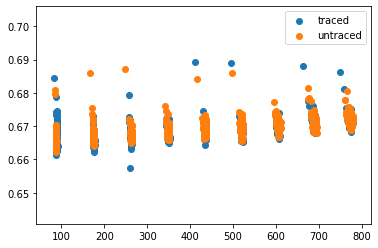

In [83]:
traced = read_file('large_batch/traced.txt')
untraced = read_file('large_batch/untraced.txt')

traced_cpu = [t[2] for t in traced]
traced_sps = [t[0] for t in traced]

untraced_cpu = [t[2] for t in untraced]
untraced_sps = [t[0] for t in untraced]

plt.scatter(traced_sps, traced_cpu, label='traced')
plt.scatter(untraced_sps, untraced_cpu, label='untraced')
plt.legend()
plt.show()

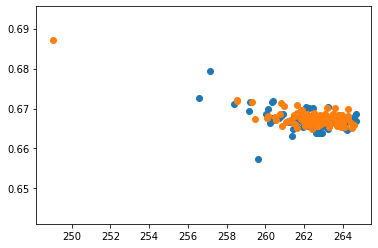

In [76]:
traced_filter = list(filter(lambda x : abs(x[0] - 250) < 50, traced))
untraced_filter = list(filter(lambda x : abs(x[0] - 250) < 50, untraced))


plt.scatter([t[0] for t in traced_filter], [t[2] for t in traced_filter], label='traced')
plt.scatter([t[0] for t in untraced_filter], [t[2] for t in untraced_filter], label='untraced')
plt.show()

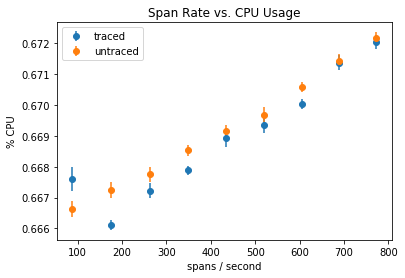

<ErrorbarContainer object of 3 artists>

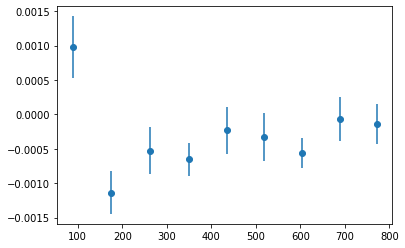

In [85]:
import numpy as np

traced_cpu = []
traced_cpu_std = []
traced_cpu_stderr = []
traced_sps = []

untraced_cpu = []
untraced_cpu_std = []
untraced_cpu_stderr = []
untraced_sps = []

for target_sps in [100, 175, 250, 350, 450, 525, 600, 700, 775]:
    traced_filter = list(filter(lambda x : abs(x[0] - target_sps) < 40, traced))
    untraced_filter = list(filter(lambda x : abs(x[0] - target_sps) < 40, untraced))
    
    traced_cpu.append(np.mean([t[2] for t in traced_filter]))
    traced_cpu_std.append(np.std([t[2] for t in traced_filter]))
    traced_sps.append(np.mean([t[0] for t in traced_filter]))
    traced_cpu_stderr.append(np.std([t[2] for t in traced_filter]) / np.sqrt(len(traced_filter)))
    
    untraced_cpu.append(np.mean([t[2] for t in untraced_filter]))
    untraced_cpu_std.append(np.std([t[2] for t in untraced_filter]))
    untraced_sps.append(np.mean([t[0] for t in untraced_filter]))
    untraced_cpu_stderr.append(np.std([t[2] for t in untraced_filter]) / np.sqrt(len(untraced_filter)))



plt.errorbar(traced_sps, traced_cpu, yerr=traced_cpu_stderr, fmt='o', label='traced')
plt.errorbar(untraced_sps, untraced_cpu, yerr=untraced_cpu_stderr, fmt='o', label='untraced')
plt.title("Span Rate vs. CPU Usage")
plt.xlabel("spans / second")
plt.ylabel("% CPU")
plt.legend()
plt.show()

combined_stderr = [ (traced_cpu_stderr[i]**2 + untraced_cpu_stderr[i]**2)**.5 for i in range(len(traced_cpu_stderr)) ]
difference = [traced_cpu[i] - untraced_cpu[i] for i in range(len(traced_cpu))]

plt.errorbar(traced_sps, difference, yerr=combined_stderr, fmt='o', label='traced')

# Program Time

Ultimately, what we care about is how much overhead it takes to send x spans per second. We don't specifically care about CPU usage -- this is a bit arbitrary to begin with since a program which takes 5% of a core on one machine can take 1% of a core on a different machine. 

We care about the **percent cost of sending spans**. If a test program takes 3 resources to run untraced, customers are interested in knowing that it will take 3.5 resources to run traced. If the test program is realistic, these numbers may actually mean something to customers. 

I have written a test program which is not multithreaded and is tuned to use 70% of a single cpu core. When comparing the test program's performance when traced / untraced, there are many sources of error. By far the biggest of these is preemption -- the OS can take control away from my process whenever it wants and give the cpu to another process. Preemeption is not random -- it increases when computers have more work (AWS has high traffic, Isaac opens Google Chrome). This makes preemption extremely challenging to deal with in our benchmarks. Programmers who want to deal with preemption need to collect *lots* of data. 

One way to get around preemption is to measure something other than CPU usage. This eliminates a major source of noise. Instead of measuring CPU usage (program time / clock time) on the y axis and spans per second (spans / clock time) on the x axis, we can change our axes to eliminate the noise introduced by preemotion. 

___

Well after this analysis we can see that Program Time is very well correlated with Clock Time, so that writeup was fairly useless...

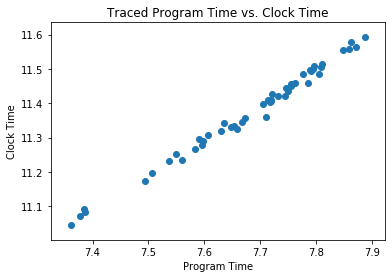

In [78]:
traced = read_file('program_time/traced.txt')
# untraced = read_file('program_time/untraced.txt')



traced_spans = [t[0] for t in traced]
traced_program_time = [t[3] for t in traced]
traced_clock_time = [t[4] for t in traced]
traced_sps = [t[0] / t[3] for t in traced] # spans / program time


plt.scatter(traced_program_time, traced_clock_time)
plt.title("Traced Program Time vs. Clock Time")
plt.xlabel("Program Time")
plt.ylabel("Clock Time")
plt.show()

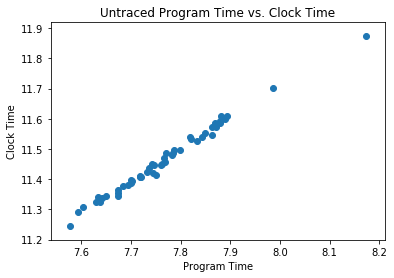

In [79]:
untraced = read_file('program_time/untraced.txt')
# untraced = read_file('program_time/untraced.txt')



untraced_spans = [t[0] for t in untraced]
untraced_program_time = [t[3] for t in untraced]
untraced_clock_time = [t[4] for t in untraced]
untraced_sps = [t[0] / t[3] for t in untraced] # spans / program time


plt.scatter(untraced_program_time, untraced_clock_time)
plt.title("Untraced Program Time vs. Clock Time")
plt.xlabel("Program Time")
plt.ylabel("Clock Time")
plt.show()

# Larger Sleep Intervals
Here we will do an analysis of larger sleeping intervals (10ms, 50ms, 100ms) and whether or not that impacts the clock time variability

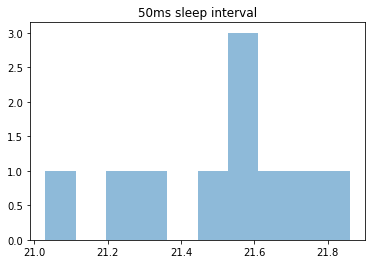

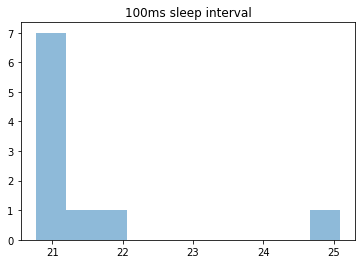

In [80]:
ms_50 = read_file('sleep_interval/50ms.txt')
ms_100 = read_file('sleep_interval/100ms.txt')


ms_50_program_time = [t[3] for t in ms_50]
ms_100_program_time = [t[3] for t in ms_100]


plt.hist(ms_50_program_time, alpha=.5, label='50ms')
plt.title('50ms sleep interval')
plt.show()

plt.hist(ms_100_program_time, alpha=.5, label='100ms')
plt.title('100ms sleep interval')
plt.show()
